In [756]:
import numpy as np
import pandas as pd
import glob 
import csv
import traceback
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns=50

sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")

### Performances

In [757]:
rslt1 = pd.read_csv('../results/performances/tkde-check-result-1636959612.562-real-t-hybrid-xgb+random-10.0.csv')
rslt2 = pd.read_csv('../results/performances/tkde-check-result-1636959630.364-real-t-xgb-single-10.0.csv')

In [758]:
rslt1.columns

Index(['runID', 'data', 'num_train', 'num_valid', 'num_test', 'num_select',
       'num_inspected', 'num_uninspected', 'num_test_illicit',
       'test_illicit_rate', 'upper_bound_precision', 'upper_bound_recall',
       'upper_bound_rev', 'sampling', 'concept_drift', 'mixing', 'ada_lr',
       'ada_decay', 'ada_epsilon', 'initial_inspection_rate',
       'current_inspection_rate', 'final_inspection_rate', 'inspection_plan',
       'mode', 'subsamplings', 'initial_weights', 'current_weights',
       'unc_mode', 'train_start', 'valid_start', 'test_start', 'test_end',
       'numWeek', 'precision', 'recall', 'revenue', 'avg_revenue',
       'norm-precision', 'norm-recall', 'norm-revenue'],
      dtype='object')

In [806]:
def drawPlot(sa, sb, ylabel, title, fname):
#     plt.style.use('seaborn-whitegrid')
    f = plt.figure()
    f.set_size_inches(6,4)
    plt.plot(pd.Series(sa), color='blue', label='Hybrid with 10% Exploration')
    plt.plot(pd.Series(sb), color='orange', label='Full Exploitation')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(loc='upper left', fontsize=12.5)
    plt.title(title, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(ticks=[0,51,103,155,207,259], labels=['2013', 14, 15, 16, 17, 18], fontsize=15)
    f.savefig(fname, bbox_inches='tight')

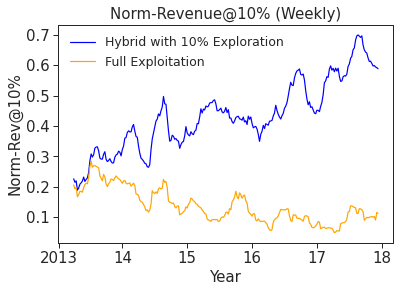

In [810]:
# Norm-revenue
nr1 = rslt1['norm-revenue'].rolling(13).mean()
nr2 = rslt2['norm-revenue'].rolling(13).mean()
drawPlot(nr1, nr2, 'Norm-Rev@10%', 'Norm-Revenue@10% (Weekly)', 'tkde-case-studies/norm-revenue.pdf')

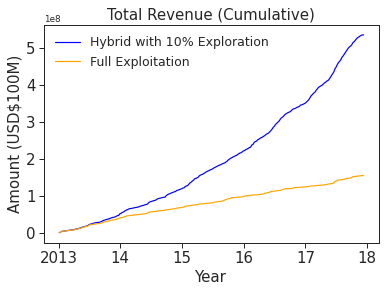

In [811]:
### cumulative sum of revenue
cumrev1 = (rslt1['avg_revenue']*rslt1['num_select']).cumsum()
cumrev2 = (rslt2['avg_revenue']*rslt2['num_select']).cumsum()
drawPlot(cumrev1, cumrev2, 'Amount (USD$100M)', 'Total Revenue (Cumulative)', 'tkde-case-studies/cumulative-revenue.pdf')

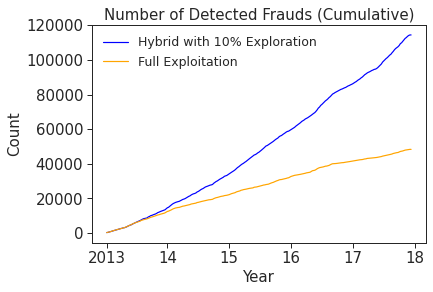

In [812]:
### Cumulative number of fraud detected
fc1 = (rslt1['precision']*rslt1['num_select']).cumsum()
fc2 = (rslt2['precision']*rslt2['num_select']).cumsum()
drawPlot(fc1, fc2, 'Count', 'Number of Detected Frauds (Cumulative)', 'tkde-case-studies/detected-fraud-count.pdf')


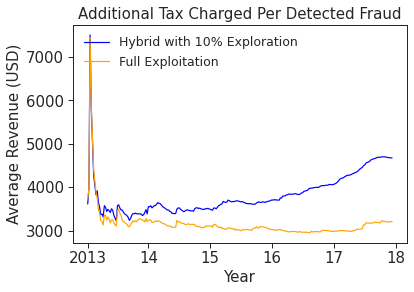

In [813]:
### cumulative sum of revenue
drawPlot(cumrev1/fc1, cumrev2/fc2, 'Average Revenue (USD)', 'Additional Tax Charged Per Detected Fraud', 'tkde-case-studies/avg-revenue-per-fraud.pdf')

## Comparison?

In [430]:
def firstCheck(df):
    """ Sorting and indexing necessary for data preparation """
    df = df.dropna(subset=["illicit"])
    df = df.sort_values("sgd.date")
    df = df.reset_index(drop=True)
    return df

In [431]:
df = firstCheck(pd.read_csv('../data/tdata.csv'))

In [432]:
# filename = '../results/query_indices/tkde-check-result-1636946508.667-real-t-hybrid-DATE+gATE-10.0/results-ep37-2015-10-17-2015-10-24.csv'
result_files = glob.glob('../results/query_indices/tkde-check-result-1636946508.667-real-t-hybrid-DATE+gATE-10.0/*')

filenum = 0
for file in result_files[:2]:
    filenum += 1
    
    old_IID = set()
    
    with open(file, "r") as f:
        reader = csv.reader(f, delimiter=",")
        expid = next(reader)[1]
        dataset = next(reader)[1]
        episode = next(reader)[1]
        start_day = next(reader)[1][2:]
        end_day = next(reader)[1][2:]

        alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)].loc[:, ['illicit', 'revenue', 'importer.id']]
        all_indices = []
        all_samps = ''

        samps = {}
        while True:
            try:
                indices = next(reader)
                samp = indices[0]
                indices = indices[1:]
                indices = list(map(int, indices))
                samps[samp]=indices
                all_indices.extend(indices)
                all_samps = all_samps + (samp + '-')
            except StopIteration:
                break
        uninspected = set(alldata.index)-set(all_indices)
        inspected = set(all_indices)
        samps['uninspected'] = uninspected
        samps['inspected']= inspected
        
        for key in samps:
            ed = alldata.loc[samps[key]]
            print('strategy:', key)
            print('size:', len(ed))
            print('illicitness:', round(np.mean(ed.illicit), 3))
            print('avgrev:', round(np.mean(ed.revenue), 3))

strategy: DATE
size: 1450
illicitness: 0.044
avgrev: 108.145
strategy: gATE
size: 161
illicitness: 0.118
avgrev: 334.768
strategy: uninspected
size: 14507
illicitness: 0.088
avgrev: 241.895
strategy: inspected
size: 1611
illicitness: 0.052
avgrev: 130.793
strategy: DATE
size: 1477
illicitness: 0.053
avgrev: 140.146
strategy: gATE
size: 164
illicitness: 0.055
avgrev: 86.806
strategy: uninspected
size: 14771
illicitness: 0.063
avgrev: 155.483
strategy: inspected
size: 1641
illicitness: 0.054
avgrev: 134.815


In [433]:
len(set(ed['importer.id']))

609

### Compare two methods and see how new importer ID increases?

In [434]:
result_files = glob.glob('../results/query_indices/tkde-check-result-1636959612.562-real-t-hybrid-xgb+random-10.0/*')
result_files2 = glob.glob('../results/query_indices/tkde-check-result-1636959630.364-real-t-xgb-single-10.0/*')

In [452]:
def inspectedNumImporters(files):
    filenum = 0
    total_inspected_goods = 0
    inspected_IID = set()
    inspected_country = set()
    inspected_tariff_code = set()
    
    numlist1 = []
    numlist2 = []
    numlist3 = []
    numlist4 = []
    numlist5 = []
    

    for file in files:
        filenum += 1    

        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]

            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)] # .loc[:, ['illicit', 'revenue', 'importer.id']]
            all_indices = []
            all_samps = ''

            samps = {}
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp]=indices
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
            uninspected = set(alldata.index)-set(all_indices)
            inspected = set(all_indices)
            samps['uninspected'] = uninspected
            samps['inspected']= inspected
            
            total_inspected_goods += len(inspected)
            inspected_IID = inspected_IID.union(set(alldata.loc[samps['inspected']]['importer.id']))
            inspected_country = inspected_country.union(set(alldata.loc[samps['inspected']]['country']))
            inspected_tariff_code = inspected_tariff_code.union(set(alldata.loc[samps['inspected']]['tariff.code']))
            
            
            numlist1.append(total_inspected_goods)        ### 1. num_weekly_inspected
            numlist2.append(len(inspected_IID))         ### 2. num_inspected_IID
            numlist3.append(len(inspected_country))         ### 3. num_inspected_country
            numlist4.append(len(inspected_tariff_code))         ### 4. num_inspected_tariff_code
            
            
            
            
    return numlist1, numlist2, numlist3, numlist4

In [453]:
df.head(3)

,sgd.date,office.id,importer.id,tariff.code,country,last.departure.code,contract.party.code,cif.value,total.taxes,gross.weight,quantity,revenue,illicit
0,15-01-01,16,IMP103557,8039010002,Pays94,Pays94,Pays295,20453.37,19084.15,39835.0,39835.0,0.0,0
1,15-01-01,11,IMP23760,32041900008,Pays138,Pays138,Pays138,88.85,10.00,3.0,3.0,0.0,0
2,15-01-01,22,IMP116740,62034231032,Pays394,Pays190,Pays190,2713.76,10.00,60.0,61.0,0.0,0


In [454]:
len(set(df['contract.party.code'])), len(set(df['last.departure.code'])), len(set(df['importer.id'])), len(set(df['tariff.code']))

(168, 175, 132893, 13387)

In [458]:
a1, a2, a3, a4 = inspectedNumImporters(result_files)
b1, b2, b3, b4 = inspectedNumImporters(result_files2)

In [773]:
#(a1, b1) , ..., (a4, b4)
pd.DataFrame(list(zip(a2, b2)), columns =['hybrid', 'exploit-only'])

,hybrid,exploit-only
0,647,577
1,904,783
2,1059,858
3,1238,952
4,1378,1006
...,...,...
252,12067,1389
253,12117,1389
254,12169,1389
255,12213,1389


In [814]:
def drawPlot(sa, sb, ylabel, title, fname):
#     plt.style.use('seaborn-whitegrid')
    f = plt.figure()
    f.set_size_inches(6,4)
    plt.plot(pd.Series(sa), color='blue', label='Hybrid with 10% Exploration')
    plt.plot(pd.Series(sb), color='orange', label='Full Exploitation')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(loc='upper left', fontsize=12.5)
    plt.title(title, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(ticks=[0,51,103,155,207,259], labels=['2013', 14, 15, 16, 17, 18], fontsize=15)
    f.savefig(fname, bbox_inches='tight')

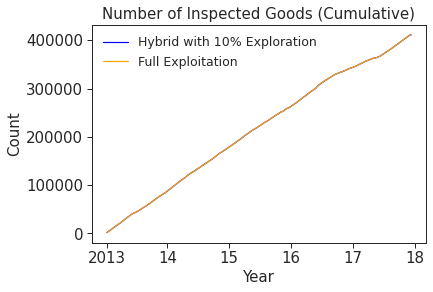

In [815]:
### 1. num_weekly_inspected
drawPlot(a1, b1, 'Count', 'Number of Inspected Goods (Cumulative)', 'tkde-case-studies/num-inspected-goods.pdf')

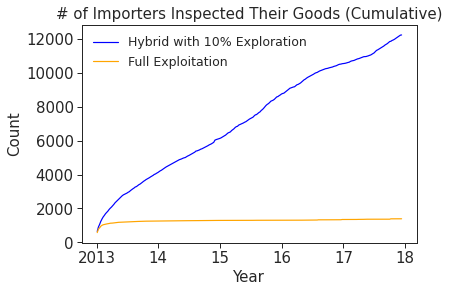

In [816]:
### 2. num_inspected_IID
drawPlot(a2, b2, 'Count', '# of Importers Inspected Their Goods (Cumulative)','tkde-case-studies/unique-importers.pdf')

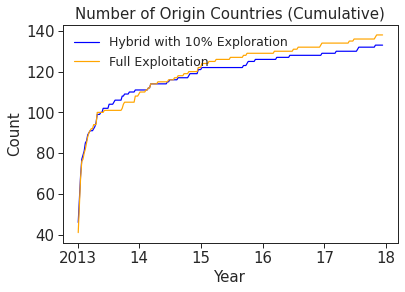

In [817]:
### 3. num_inspected_country
drawPlot(a3, b3, 'Count', 'Number of Origin Countries (Cumulative)', 'tkde-case-studies/country-of-origin.pdf')

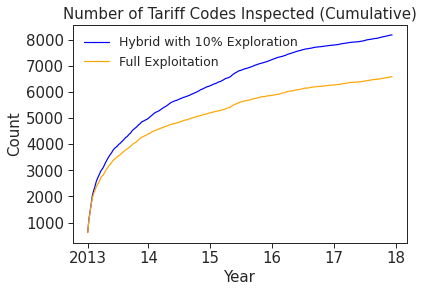

In [818]:
### 4. num_inspected_tariff_code
drawPlot(a4, b4, 'Count', 'Number of Tariff Codes Inspected (Cumulative)', 'tkde-case-studies/tariff-codes.pdf')

### importer coverage  = inspected importers / total # of importers
#### How much importer is covered by the algorithm


In [507]:
def importerCoverage(files):
    filenum = 0
    total_inspected_goods = 0
    inspected_IID = set()
    inspected_country = set()
    inspected_tariff_code = set()
    known_IID = set()
    
    numlist1 = []
    numlist2 = []
    

    for file in files:
        filenum += 1    

        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]
            
            initial_data = df[df['sgd.date'] <= '15-01-03']
            initial_IID = set(initial_data['importer.id'])
            known_IID = known_IID.union(initial_IID)
            
#             print(start_day)
            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)] # .loc[:, ['illicit', 'revenue', 'importer.id']]
            all_indices = []
            all_samps = ''

            samps = {}
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp]=indices
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
                    
            uninspected = set(alldata.index)-set(all_indices)
            inspected = set(all_indices)
            samps['uninspected'] = uninspected
            samps['inspected']= inspected
            
            
            items_known_importers = alldata[alldata['importer.id'].isin(known_IID)]
            
            current_IID = set(alldata['importer.id'])
            current_known_IID = current_IID.intersection(known_IID)
            
            numlist1.append(len(current_known_IID)/len(current_IID))
            numlist2.append(len(items_known_importers)/len(alldata))
            
            # update known_IID with inspected items
            known_IID = known_IID.union(set(alldata.loc[samps['inspected']]['importer.id']))
            
            
#             numlist2.append(len(inspected_IID))         ### 2. num_inspected_IID
#             for key in samps:
#                 ed = alldata.loc[samps[key]]
#                 print('strategy:', key)
#                 print('size:', len(ed))
#                 print('illicitness:', round(np.mean(ed.illicit), 3))
#                 print('avgrev:', round(np.mean(ed.revenue), 3))
            
            
    return numlist1, numlist2, known_IID

In [508]:
ica1, ica2, known_IIDa = importerCoverage(result_files)
icb1, icb2, known_IIDb = importerCoverage(result_files2)

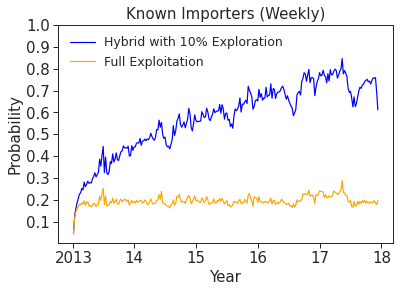

In [858]:
### 5. importer_coverage
# Ratio of known importers (Probability of known importers)
drawPlot2(ica1, icb1, 'Probability', 'Known Importers (Weekly)', 'tkde-case-studies/ratio-of-importer-observed.pdf')

In [862]:
def drawPlot2(sa, sb, ylabel, title, fname):
#     plt.style.use('seaborn-whitegrid')
    f = plt.figure()
    f.set_size_inches(6,4)
    plt.plot(pd.Series(sa), color='blue', label='Hybrid with 10% Exploration')
    plt.plot(pd.Series(sb), color='orange', label='Full Exploitation')
    plt.xlabel('Year', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(loc='upper left', fontsize=12.5)
    plt.title(title, fontsize=15)
#     plt.ylim([0,1.1])
    plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=15)
    plt.xticks(ticks=[0,51,103,155,207,259], labels=['2013', 14, 15, 16, 17, 18], fontsize=15)
    f.savefig(fname, bbox_inches='tight')

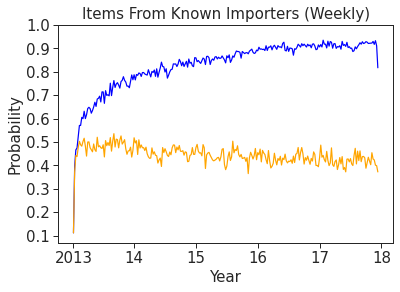

In [831]:
### 6. item_coverage
# Ratio of items from known importers (Probability of an item imported from a known importer)
drawPlot2(ica2, icb2, 'Probability', 'Items From Known Importers (Weekly)', 'tkde-case-studies/items-with-known-importers.pdf')

### Tariff code coverage  = inspected tariff codes / total # of tariff codes
#### How much tariff codes is covered by the algorithm


In [825]:
def tariffCoverage(files):
    filenum = 0
    total_inspected_goods = 0
    inspected_tariff_code = set()
    inspected_country = set()
    inspected_tariff_code = set()
    known_tariff_code = set()
    
    numlist1 = []
    numlist2 = []
    

    for file in files:
        filenum += 1    

        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]
            
            initial_data = df[df['sgd.date'] <= '15-01-03']
            initial_tariff_code = set(initial_data['tariff.code'])
            known_tariff_code = known_tariff_code.union(initial_tariff_code)
            
#             print(start_day)
            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)] # .loc[:, ['illicit', 'revenue', 'tariff.code']]
            all_indices = []
            all_samps = ''

            samps = {}
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp]=indices
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
                    
            uninspected = set(alldata.index)-set(all_indices)
            inspected = set(all_indices)
            samps['uninspected'] = uninspected
            samps['inspected']= inspected
            
            
            items_known_importers = alldata[alldata['tariff.code'].isin(known_tariff_code)]
            
            current_tariff_code = set(alldata['tariff.code'])
            current_known_tariff_code = current_tariff_code.intersection(known_tariff_code)
            
            numlist1.append(len(current_known_tariff_code)/len(current_tariff_code))
            numlist2.append(len(items_known_importers)/len(alldata))
            
            # update known_tariff_code with inspected items
            known_tariff_code = known_tariff_code.union(set(alldata.loc[samps['inspected']]['tariff.code']))
            
            
    return numlist1, numlist2, known_tariff_code

In [826]:
ta1, ta2, known_codesa = tariffCoverage(result_files)
tb1, tb2, known_codesb = tariffCoverage(result_files2)

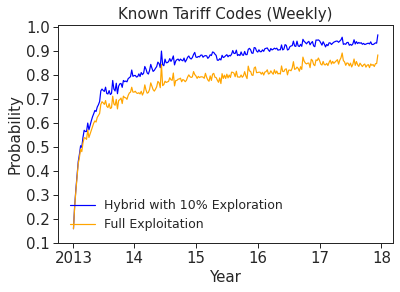

In [861]:
### 5. tariff_code_coverage
# Ratio of known tariff codes (Probability of known tariff codes)
drawPlot2(ta1, tb1, 'Probability', 'Known Tariff Codes (Weekly)', 'tkde-case-studies/ratio-of-tariff-code-observed.pdf')

### Importer ID + Tariff code combination coverage

In [842]:
df['imp+code'] = df['importer.id'] + '-' + df['tariff.code'].astype(str)

In [848]:
def IMPCodeCoverage(files):
    filenum = 0
    total_inspected_goods = 0
    inspected_imp_tariff_code = set()
    inspected_country = set()
    inspected_imp_tariff_code = set()
    known_imp_tariff_code = set()
    
    numlist1 = []
    numlist2 = []
    

    for file in files:
        filenum += 1    

        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]
            
            initial_data = df[df['sgd.date'] <= '15-01-03']
            initial_imp_tariff_code = set(initial_data['imp+code'])
            known_imp_tariff_code = known_imp_tariff_code.union(initial_imp_tariff_code)
            
#             print(start_day)
            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)] # .loc[:, ['illicit', 'revenue', 'imp+code']]
            all_indices = []
            all_samps = ''

            samps = {}
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp]=indices
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
                    
            uninspected = set(alldata.index)-set(all_indices)
            inspected = set(all_indices)
            samps['uninspected'] = uninspected
            samps['inspected']= inspected
            
            
            current_imp_tariff_code = set(alldata['imp+code'])
            current_known_imp_tariff_code = current_imp_tariff_code.intersection(known_imp_tariff_code)
            
            numlist1.append(len(current_known_imp_tariff_code)/len(current_imp_tariff_code))
            
            # update known_imp_tariff_code with inspected items
            known_imp_tariff_code = known_imp_tariff_code.union(set(alldata.loc[samps['inspected']]['imp+code']))
            
            
    return numlist1, known_imp_tariff_code

In [849]:
ita1, known_codesa = IMPCodeCoverage(result_files)
itb1, known_codesb = IMPCodeCoverage(result_files2)

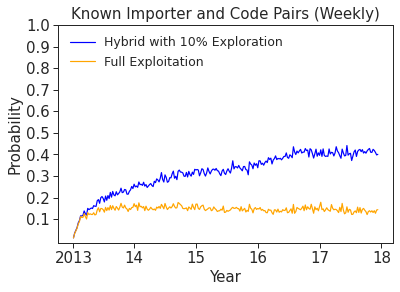

In [863]:
### 5. tariff_code_coverage
# Ratio of known tariff codes (Probability of known tariff codes)
drawPlot2(ita1, itb1, 'Probability', 'Known Importer and Code Pairs (Weekly)', 'tkde-case-studies/ratio-of-impID+tariff-code-observed.pdf')

#### Hybrid (exploration)를 이용하여 검사하였기에, 새롭게 파악된 우범 importer와 등장 시기. 


In [593]:
def inspected_indices(files):
    filenum = 0
    samps = dict()
    samps['xgb']=dict()
    samps['random']=dict()

    for file in files:
        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]
            initial_data = df[df['sgd.date'] <= '15-01-03']
            initial_IID = set(initial_data['importer.id'])
            
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp][filenum]=indices
                except StopIteration:
                    break
                    
            filenum += 1
    return samps

In [592]:
samps1 = inspected_indices(result_files)
samps2 = inspected_indices(result_files2)

In [598]:
randomind = [item for elem in list(samps1['random'].values()) for item in elem]

In [618]:
xgbind1 = [item for elem in list(samps1['xgb'].values()) for item in elem]

In [601]:
xgbind2 = [item for elem in list(samps2['xgb'].values()) for item in elem]

In [621]:
#dataframe subsample selected by exploration

# random fraud ratio
rdf = df.loc[sorted(list(set(randomind)-set(xgbind2)))]
rdfimp = set(rdf['importer.id'])

rfratio = df[df['importer.id'].isin(rdfimp)].groupby('importer.id')['illicit'].apply(np.mean).sort_values()
rfratio[rfratio < 0.9]

importer.id
IMP492       0.000000
IMP75590     0.000000
IMP124686    0.000000
IMP124697    0.000000
IMP22850     0.000000
               ...   
IMP110970    0.892308
IMP28677     0.894737
IMP132002    0.896825
IMP133662    0.897810
IMP76864     0.898374
Name: illicit, Length: 8333, dtype: float64

In [1062]:
dfxgb1 = df.loc[xgbind1]
dfrandom1 = df.loc[randomind]
dfxgb2 = df.loc[xgbind2]

In [1063]:
df['hybrid'] = 0
df['hybrid'].loc[xgbind1] = 'xgb'
df['hybrid'].loc[randomind] = 'random'
df['xgb'] = 0
df['xgb'].loc[xgbind2] = 'xgb'

/home/sundong/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [1064]:
len(set(allind))

666170

In [1065]:
allind = [xgbind1, randomind, xgbind2]
allind = sorted(list(set([item for elem in allind for item in elem])))

In [1075]:
# ic = importer_count
ic_hybrid = df.loc[allind][df.hybrid != 0]['importer.id'].nunique()
ic_fullexploit = df.loc[allind][df.xgb != 0]['importer.id'].nunique()
ic_hybrid_exploit = df.loc[xgbind1]['importer.id'].nunique()
ic_hybrid_explore = df.loc[randomind]['importer.id'].nunique()

ic_hybrid, ic_fullexploit, ic_hybrid_exploit, ic_hybrid_explore

<ipython-input-1075-1bc8a504079b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic_hybrid = df.loc[allind][df.hybrid != 0]['importer.id'].nunique()
<ipython-input-1075-1bc8a504079b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic_fullexploit = df.loc[allind][df.xgb != 0]['importer.id'].nunique()


(12225, 1392, 7944, 8557)

In [1017]:
def aggre(item):
    ll = []
    ll.append(item.values)
    ll = ll[0]
    
    return ll

def explore_effect(logs):
    if len(logs) > 2 and logs[0] == 'random' and 'xgb' in set(logs) and list(logs).count('xgb') > list(logs).count('random'):
        return True
    else:
        return False
    
def explore_effect2(logs):
    if len(logs) > 2 and logs[0] == 'random' and 'xgb' in set(logs):
        return True
    else:
        return False

inspection_logs = df.loc[allind].groupby(['importer.id'])['hybrid'].apply(aggre)

In [1052]:
inspection_logs.head(100).tail(10).apply(explore_effect)

importer.id
IMP101174    False
IMP101194    False
IMP101197    False
IMP101207    False
IMP101243    False
IMP101276    False
IMP1013       True
IMP101313    False
IMP101315    False
IMP10133      True
Name: hybrid, dtype: bool

In [1033]:
inspection_logs.loc['IMP10133']

array(['random', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb'],
      dtype=object)

In [1037]:
sum(inspection_logs.apply(explore_effect))

1652

In [1045]:
inspection_logs.loc[inspection_logs.apply(explore_effect)]


importer.id
IMP100225                    [random, xgb, xgb, xgb, xgb, xgb]
IMP100289    [random, xgb, random, xgb, xgb, xgb, xgb, xgb,...
IMP10030                               [random, xgb, xgb, xgb]
IMP100371    [random, xgb, xgb, xgb, xgb, xgb, xgb, xgb, xg...
IMP10048     [random, xgb, xgb, xgb, xgb, xgb, xgb, xgb, xg...
                                   ...                        
IMP99483     [random, xgb, xgb, xgb, xgb, xgb, xgb, xgb, xg...
IMP995       [random, random, random, xgb, xgb, xgb, xgb, x...
IMP99598           [random, xgb, xgb, xgb, xgb, xgb, xgb, xgb]
IMP9991      [random, xgb, xgb, xgb, xgb, xgb, xgb, xgb, xg...
IMP9999      [random, random, xgb, xgb, xgb, xgb, xgb, xgb,...
Name: hybrid, Length: 1652, dtype: object

In [1049]:
sum(inspection_logs.loc[inspection_logs.apply(explore_effect)].apply(len))

170683

In [1055]:
subject_imp = inspection_logs.loc[inspection_logs.apply(explore_effect)].index
df.loc[allind][df['importer.id'].isin(subject_imp)]

simpdf = df.loc[allind][df['importer.id'].isin(subject_imp)]
simpdf

<ipython-input-1055-be2a44d53cc3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[allind][df['importer.id'].isin(subject_imp)]
<ipython-input-1055-be2a44d53cc3>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simpdf = df.loc[allind][df['importer.id'].isin(subject_imp)]


,sgd.date,office.id,importer.id,tariff.code,country,last.departure.code,contract.party.code,cif.value,total.taxes,gross.weight,quantity,revenue,illicit,hybrid,xgb,imp+code
61275,15-01-31,16,IMP86132,87088035005,Pays205,Pays205,Pays205,1701.21,956.37,43.0,43.0,0.0,0,random,0,IMP86132-87088035005
61278,15-01-31,16,IMP86132,90262080092,Pays205,Pays205,Pays205,9041.39,558.75,225.0,92.0,0.0,0,random,0,IMP86132-90262080092
61902,15-01-31,47,IMP23977,84039090008,Pays125,Pays125,Pays190,124561.30,24607.57,2130.0,5540.0,0.0,0,random,0,IMP23977-84039090008
62216,15-01-31,3,IMP66788,38220000092,Pays450,Pays138,Pays125,23814.84,1471.75,460.0,460.0,0.0,0,random,0,IMP66788-38220000092
62419,15-01-31,13,IMP13955,92071010008,Pays78,Pays78,Pays78,4642.23,10.00,221.0,148.0,0.0,0,random,0,IMP13955-92071010008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171342,19-12-30,4,IMP113232,96039099990,Pays78,Pays449,Pays449,109.83,10.00,30.0,10.0,0.0,0,xgb,0,IMP113232-96039099990
4171357,19-12-30,3,IMP134897,40169300000,Pays378,Pays125,Pays125,6.09,13.40,1.0,1.0,0.0,0,xgb,0,IMP134897-40169300000
4171361,19-12-30,3,IMP134897,39199080009,Pays420,Pays125,Pays125,83.76,61.79,1.0,1.0,0.0,0,xgb,0,IMP134897-39199080009
4171363,19-12-30,3,IMP134897,85389099025,Pays420,Pays125,Pays125,8.32,14.65,1.0,1.0,0.0,0,xgb,0,IMP134897-85389099025


In [1061]:
len(set(simpdf[simpdf['xgb'] == 'xgb']['importer.id']))

74

In [715]:
df.loc[allind][df['importer.id'] == 'IMP106062'].sort_index().head(5)

<ipython-input-715-b981636f1e3e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[allind][df['importer.id'] == 'IMP106062'].sort_index().head(5)


,sgd.date,office.id,importer.id,tariff.code,country,last.departure.code,contract.party.code,cif.value,total.taxes,gross.weight,quantity,revenue,illicit,hybrid,xgb
2371815,17-08-30,12,IMP106062,82055980090,Pays78,Pays78,Pays78,478.41,214.66,157.0,1500.0,70.59,1,random,0
2388389,17-09-09,12,IMP106062,84329000918,Pays78,Pays78,Pays78,2312.48,476.37,720.0,720.0,0.00,0,xgb,0
2638768,17-12-29,12,IMP106062,84669280003,Pays78,Pays78,Pays78,2953.68,547.61,700.0,700.0,774.71,1,xgb,0
2813913,18-03-16,12,IMP106062,44119290002,Pays396,Pays396,Pays396,83376.62,21426.54,70840.0,70840.0,0.00,0,xgb,0
2887451,18-04-14,12,IMP106062,70051025016,Pays78,Pays78,Pays78,84752.76,48789.37,150000.0,16101.0,2387.34,1,xgb,0


In [734]:
# This importer has not been subjected to physical inspection before random exploration.
sum(df[df['importer.id'] == 'IMP106062'].sort_index()[:107]['hybrid'])

0

In [737]:
sum(df[df['importer.id'] == 'IMP106062'].sort_index()[:107]['xgb'])

0

In [755]:
df[df['importer.id'] == 'IMP106062'].sort_index()[0:][['sgd.date', 'revenue', 'illicit', 'hybrid', 'xgb']]

,sgd.date,revenue,illicit,hybrid,xgb
68488,15-02-04,0.00,0,0,0
68489,15-02-04,0.00,0,0,0
119629,15-02-25,0.00,0,0,0
249936,15-04-16,0.00,0,0,0
269764,15-04-24,0.00,0,0,0
366682,15-05-30,0.00,0,0,0
366686,15-05-30,0.00,0,0,0
366691,15-05-30,0.00,0,0,0
366934,15-05-30,0.00,0,0,0
411812,15-06-16,0.00,0,0,0


In [751]:
pd.options.display.max_rows=180

In [750]:
# On his 108th trade, IMP106062 is subjected to physical inspection by random exploration.
df[df['importer.id'] == 'IMP106062'].sort_index()[107:]

,sgd.date,office.id,importer.id,tariff.code,country,last.departure.code,contract.party.code,cif.value,total.taxes,gross.weight,quantity,revenue,illicit,hybrid,xgb
2371815,17-08-30,12,IMP106062,82055980090,Pays78,Pays78,Pays78,478.41,214.66,157.0,1500.0,70.59,1,random,0
2371827,17-08-30,12,IMP106062,82089000907,Pays78,Pays78,Pays78,3189.43,630.08,728.0,10000.0,70.59,1,0,0
2371828,17-08-30,12,IMP106062,90191090208,Pays78,Pays78,Pays78,483.24,131.19,105.0,105.0,70.59,1,0,0
2371829,17-08-30,12,IMP106062,70193900005,Pays78,Pays78,Pays78,2143.30,397.36,1418.0,1418.0,70.59,1,0,0
2371843,17-08-30,12,IMP106062,73181558201,Pays78,Pays78,Pays78,10912.94,4808.60,5750.0,5750.0,70.59,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3683688,19-05-22,12,IMP106062,84659120905,Pays78,Pays172,Pays172,32971.14,2377.21,9270.0,10.0,298.11,1,xgb,0
3720873,19-06-27,12,IMP106062,73181558201,Pays78,Pays172,Pays172,33289.03,19163.39,28180.0,28180.0,13286.05,1,xgb,0
3785603,19-07-29,13,IMP106062,70051030015,Pays283,Pays172,Pays172,125126.40,72031.16,184100.0,18785.0,0.00,0,0,0
4086624,19-11-25,16,IMP106062,70051030015,Pays283,Pays172,Pays172,89438.32,51486.69,154800.0,13559.0,14937.85,1,0,0


In [747]:
df[df['importer.id'] == 'IMP106062'].sort_index()[:108]['hybrid']

68488           0
68489           0
119629          0
249936          0
269764          0
            ...  
2343933         0
2370794         0
2371711         0
2371812         0
2371815    random
Name: hybrid, Length: 108, dtype: object

In [929]:
df.loc[allind]['hybrid'].value_counts()

xgb       369849
0         255221
random     41100
Name: hybrid, dtype: int64

In [930]:
df.loc[allind]['xgb'].value_counts()

xgb    410949
0      255221
Name: xgb, dtype: int64

###  Some useful stats

In [1076]:
len(dfrandom1), len(dfxgb1), len(dfxgb2)

(41100, 369849, 410949)

In [1077]:
len(set(dfxgb1['importer.id'])), len(set(dfrandom1['importer.id']))

(7944, 8557)

In [1078]:
len(set(dfxgb1['importer.id']).intersection(set(dfrandom1['importer.id'])))

4276

In [1079]:
comp1 = df.loc[allind][(df['hybrid']=='xgb') & (df['xgb']==0)]
comp2 = df.loc[allind][(df['hybrid']=='xgb') & (df['xgb']=='xgb')]
comp3 = df.loc[allind][(df['hybrid']==0) & (df['xgb']=='xgb')]
comp4 = df.loc[allind][(df['hybrid']=='random') & (df['xgb']==0)]
comp5 = df.loc[allind][(df['hybrid']=='random') & (df['xgb']=='xgb')]

<ipython-input-1079-a96f4661cf27>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp1 = df.loc[allind][(df['hybrid']=='xgb') & (df['xgb']==0)]
<ipython-input-1079-a96f4661cf27>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp2 = df.loc[allind][(df['hybrid']=='xgb') & (df['xgb']=='xgb')]
<ipython-input-1079-a96f4661cf27>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp3 = df.loc[allind][(df['hybrid']==0) & (df['xgb']=='xgb')]
<ipython-input-1079-a96f4661cf27>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp4 = df.loc[allind][(df['hybrid']=='random') & (df['xgb']==0)]
<ipython-input-1079-a96f4661cf27>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp5 = df.loc[allind][(df['hybrid']=='random') & (df['xgb']=='xgb')]


In [1080]:
len(comp1), len(comp2), len(comp3), len(comp4), len(comp5)

(216935, 152914, 255221, 38286, 2814)

In [1081]:
len(set(comp1['importer.id'])), len(set(comp2['importer.id'])),len(set(comp3['importer.id'])), len(set(comp4['importer.id'])), len(set(comp5['importer.id']))

(7547, 1216, 785, 8509, 235)

In [1082]:
np.mean(comp1['illicit']), np.mean(comp2['illicit']), np.mean(comp3['illicit']), np.mean(comp4['illicit']), np.mean(comp5['illicit'])

(0.3636527070320603,
 0.21682121977059002,
 0.058780429510110845,
 0.05819359557018231,
 0.05543710021321962)

In [1083]:
np.mean(comp1['revenue']), np.mean(comp2['revenue']), np.mean(comp3['revenue']), np.mean(comp4['revenue']), np.mean(comp5['revenue'])

(1881.9179678243993,
 781.9683028041965,
 137.99203055391237,
 179.78983884448635,
 128.98854655294957)

In [953]:
len(set(comp1['tariff.code'])), len(set(comp2['tariff.code'])),len(set(comp3['tariff.code'])), len(set(comp4['tariff.code'])), len(set(comp5['tariff.code']))

(6351, 5228, 5473, 5558, 990)

In [636]:
dfxgb1['importer.id'].value_counts().head(10)

IMP115521    9641
IMP48709     6174
IMP110997    5834
IMP29823     5165
IMP78703     4734
IMP133562    4166
IMP31610     3902
IMP114       3832
IMP2164      3582
IMP464       3131
Name: importer.id, dtype: int64

In [633]:
dfrandom1['importer.id'].value_counts()

IMP102978    715
IMP29823     511
IMP114       501
IMP110997    442
IMP224       392
            ... 
IMP112026      1
IMP120938      1
IMP68220       1
IMP111922      1
IMP139151      1
Name: importer.id, Length: 8557, dtype: int64

In [638]:
dfxgb2['importer.id'].value_counts().head(10)

IMP29823     36114
IMP110997    23292
IMP464       20195
IMP112514    14319
IMP48709     13396
IMP83        10948
IMP115521    10541
IMP43109      8867
IMP27516      8487
IMP487        8138
Name: importer.id, dtype: int64

In [661]:
dfxgb1[dfxgb1['importer.id'].isin((set(dfxgb1['importer.id'])-set(dfxgb2['importer.id'])).intersection(set(dfrandom1['importer.id'])))].groupby(['importer.id'])['total.taxes'].apply(np.max).sort_values(ascending=False)

importer.id
IMP111461    5353770.0
IMP634       4327616.0
IMP20347     4220645.0
IMP105265    3224624.0
IMP120081    2908862.0
               ...    
IMP112417         10.0
IMP94715          10.0
IMP140111         10.0
IMP112459         10.0
IMP124959         10.0
Name: total.taxes, Length: 3460, dtype: float64

In [662]:
dfxgb1[dfxgb1['importer.id'].isin((set(dfxgb1['importer.id'])-set(dfxgb2['importer.id'])).intersection(set(dfrandom1['importer.id'])))].groupby(['importer.id'])['revenue'].apply(np.mean).sort_values(ascending=False)

importer.id
IMP120081    79060.240000
IMP118920    52320.407429
IMP31993     46736.170000
IMP119397    42963.430000
IMP138022    35520.342162
                 ...     
IMP7000          0.000000
IMP7004          0.000000
IMP70064         0.000000
IMP134108        0.000000
IMP9999          0.000000
Name: revenue, Length: 3460, dtype: float64

In [668]:
lla = list(dfxgb1[dfxgb1['importer.id'].isin((set(dfxgb1['importer.id'])-set(dfxgb2['importer.id'])).intersection(set(dfrandom1['importer.id'])))].groupby(['importer.id'])['total.taxes'].apply(np.max).sort_values(ascending=False).index)

In [669]:
llb = list(dfxgb1[dfxgb1['importer.id'].isin((set(dfxgb1['importer.id'])-set(dfxgb2['importer.id'])).intersection(set(dfrandom1['importer.id'])))].groupby(['importer.id'])['revenue'].apply(np.mean).sort_values(ascending=False).index)

In [672]:
def istn(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

istn(llb, lla)

['IMP120081',
 'IMP118920',
 'IMP31993',
 'IMP119397',
 'IMP138022',
 'IMP138425',
 'IMP135196',
 'IMP137925',
 'IMP139521',
 'IMP105730',
 'IMP86296',
 'IMP129832',
 'IMP126725',
 'IMP128670',
 'IMP134321',
 'IMP134977',
 'IMP75048',
 'IMP117677',
 'IMP140158',
 'IMP127128',
 'IMP115534',
 'IMP72776',
 'IMP113212',
 'IMP136188',
 'IMP119281',
 'IMP91269',
 'IMP14916',
 'IMP100371',
 'IMP111435',
 'IMP88656',
 'IMP137898',
 'IMP137295',
 'IMP47524',
 'IMP86501',
 'IMP118976',
 'IMP29232',
 'IMP104936',
 'IMP71721',
 'IMP5339',
 'IMP107429',
 'IMP132263',
 'IMP132987',
 'IMP111935',
 'IMP135911',
 'IMP121805',
 'IMP118751',
 'IMP1109',
 'IMP131960',
 'IMP127793',
 'IMP113443',
 'IMP136169',
 'IMP119218',
 'IMP136106',
 'IMP120968',
 'IMP125493',
 'IMP137808',
 'IMP130806',
 'IMP118997',
 'IMP4859',
 'IMP133598',
 'IMP123535',
 'IMP133492',
 'IMP28677',
 'IMP136496',
 'IMP132002',
 'IMP118600',
 'IMP135027',
 'IMP131822',
 'IMP133435',
 'IMP113208',
 'IMP112058',
 'IMP119986',
 'IMP12198

In [678]:
df[df['importer.id']]

KeyError: "None of [Index(['IMP103557', 'IMP23760', 'IMP116740', 'IMP40824', 'IMP40824',\n       'IMP23760', 'IMP23760', 'IMP23760', 'IMP23760', 'IMP23760',\n       ...\n       'IMP79186', 'IMP113233', 'IMP11798', 'IMP86633', 'IMP29823', 'IMP29823',\n       'IMP29823', 'IMP29823', 'IMP99627', 'IMP120721'],\n      dtype='object', length=4171650)] are in the [columns]"

In [ ]:
### leftover code

In [540]:
explored_IID = known_IIDa - known_IIDb

In [513]:
len(known_IIDa), len(known_IIDb), len(explored_IID)

(12318, 1603, 10745)

In [536]:
ir_imp = df[df['importer.id'].isin(explored_IID)].groupby(['importer.id'])['revenue'].apply(np.max).sort_values()
# ir_imp[ir_imp < 1].sort_values()

In [537]:
ir_imp

importer.id
IMP135399         0.00
IMP1321           0.00
IMP6358           0.00
IMP132097         0.00
IMP132095         0.00
               ...    
IMP29633     338000.00
IMP30439     338560.44
IMP3390      394899.20
IMP120081    395301.20
IMP3360      415217.30
Name: revenue, Length: 10745, dtype: float64

In [539]:
df[df['importer.id'] == 'IMP120081']

,sgd.date,office.id,importer.id,tariff.code,country,last.departure.code,contract.party.code,cif.value,total.taxes,gross.weight,quantity,revenue,illicit
538225,15-08-19,17,IMP120081,84552100009,Pays190,Pays190,Pays190,663317.00,10.00,42811.0,1.0,0.0,0
538295,15-08-19,17,IMP120081,84552100009,Pays190,Pays190,Pays190,250070.60,10.00,17100.0,1.0,0.0,0
584575,15-09-07,17,IMP120081,84552100009,Pays190,Pays190,Pays190,1674342.00,10.00,151748.0,1.0,0.0,0
584577,15-09-07,17,IMP120081,84552100009,Pays190,Pays190,Pays190,523871.80,32375.28,48600.0,1.0,0.0,0
607564,15-09-16,17,IMP120081,84552100009,Pays190,Pays190,Pays190,421047.00,26020.70,5120.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151002,19-12-19,47,IMP120081,84818099918,Pays138,Pays28,Pays28,6908.98,1436.77,9.0,9.0,0.0,0
4151031,19-12-19,47,IMP120081,84818099918,Pays352,Pays28,Pays28,5199.80,1081.33,7.0,7.0,0.0,0
4151032,19-12-19,47,IMP120081,90322000001,Pays138,Pays28,Pays28,2363.24,175.42,3.0,10.0,0.0,0
4151033,19-12-19,47,IMP120081,84811019903,Pays352,Pays28,Pays28,1766.35,367.32,2.0,2.0,0.0,0


### 맞은 거 틀린 거


In [478]:
def caseAnalysis(files):
    filenum = 0
    total_inspected_goods = 0
    inspected_IID = set()
    inspected_country = set()
    inspected_tariff_code = set()
    
    numlist1 = []
    numlist2 = []
    numlist3 = []
    numlist4 = []
    numlist5 = []
    

    for file in files[255:256]:
        filenum += 1    

        with open(file, "r") as f:
            reader = csv.reader(f, delimiter=",")
            expid = next(reader)[1]
            dataset = next(reader)[1]
            episode = next(reader)[1]
            start_day = next(reader)[1][2:]
            end_day = next(reader)[1][2:]

            alldata = df[(df['sgd.date'] < end_day) & (df['sgd.date'] >= start_day)] # .loc[:, ['illicit', 'revenue', 'importer.id']]
            all_indices = []
            all_samps = ''

            samps = {}
            while True:
                try:
                    indices = next(reader)
                    samp = indices[0]
                    indices = indices[1:]
                    indices = list(map(int, indices))
                    samps[samp]=indices
                    all_indices.extend(indices)
                    all_samps = all_samps + (samp + '-')
                except StopIteration:
                    break
            uninspected = set(alldata.index)-set(all_indices)
            inspected = set(all_indices)
            samps['uninspected'] = uninspected
            samps['inspected']= inspected
            
            total_inspected_goods += len(inspected)
            inspected_IID = inspected_IID.union(set(alldata.loc[samps['inspected']]['importer.id']))
            inspected_country = inspected_country.union(set(alldata.loc[samps['inspected']]['country']))
            inspected_tariff_code = inspected_tariff_code.union(set(alldata.loc[samps['inspected']]['tariff.code']))
            
            
#             numlist1.append(total_inspected_goods)        ### 1. num_weekly_inspected
#             numlist2.append(len(inspected_IID))         ### 2. num_inspected_IID
#             numlist3.append(len(inspected_country))         ### 3. num_inspected_country
#             numlist4.append(len(inspected_tariff_code))         ### 4. num_inspected_tariff_code
            
            for key in samps:
                ed = alldata.loc[samps[key]]
                print('strategy:', key)
                print('size:', len(ed))
                print('illicitness:', round(np.mean(ed.illicit), 3))
                print('avgrev:', round(np.mean(ed.revenue), 3))
            
            
    return 0

In [479]:
caseAnalysis(result_files)
# inspectedNumImporters(result_files2)

strategy: xgb
size: 1292
illicitness: 0.225
avgrev: 851.541
strategy: random
size: 143
illicitness: 0.014
avgrev: 4.488
strategy: uninspected
size: 12917
illicitness: 0.028
avgrev: 56.767
strategy: inspected
size: 1435
illicitness: 0.204
avgrev: 767.131


0